# Imports

In [ ]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip -q install ktrain requests

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 57.6 MB/s 
     |████████████████████████████████| 265 kB 69.8 MB/s 
     |████████████████████████████████| 3.8 MB 36.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.1 MB/s 
     |████████████████████████████████| 468 kB 12.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.8 MB/s 
     |████████████████████████████████| 880 kB 51.3 MB/s 
     |████████████████████████████████| 182 kB 38.5 MB/s 


In [ ]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 516 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences
from spacy.training import offsets_to_biluo_tags

# Utils

In [ ]:
nlp = spacy.load('pt_core_news_sm')

entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds,preds2):
    #print(preds)
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrencia que não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,preds2,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    ent = text[p2[0]:p2[1]]
                    label = p2[2]
                    #print(ent)
                    text_aux = text[p1[1]:]
                    idx0 = p1[0]
                    idx1 = p1[1]
                    flag = 0
                    while flag == 0:
                        flag = 1
                        span = get_span(text_aux,label,ent)
                        #print(span)
                        for p3 in preds:
                            # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                            if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                                #print('p3[0]:',p3[0])
                                #print('p3[1]:',p3[1])
                                flag = 0
                                text_aux = text[p3[1]:]
                                #print(text_aux)
                                idx0 = p3[0]
                                idx1 = p3[1]
                                # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                                # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                                #break
                    if(span['start']!=0 and span['end']!=0):
                        #print('trocou p1: ', p1)
                        #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                        preds.remove(p2)
                        preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                        return preds,preds2,0
                    else:
                        #print('removeu p1: ', p1)
                        preds2.append(p1)
                        preds.remove(p1)
                        return preds,preds2,0
    return preds,preds2,1

def mix_final_preds(final_preds):
    for i in range(len(final_preds)):
        for j in range(i,len(final_preds)):
            for p1 in final_preds[i]:
                flag = 1
                for p2 in final_preds[j]:
                    if ((p2[0]<=p1[0]<=p2[1]) or (p2[0]<=p1[1]<=p2[1]) or (p1[0]<=p2[0]<=p1[1]) or (p1[0]<=p2[1]<=p1[1])):
                        flag = 0
                if flag==1:
                    final_preds[j].append(p1)
    return final_preds

def rec_ajust_preds(text,preds):
    final_preds = []
    preds2 = []
    teste = 0
    while teste != 1:
        preds,preds2, teste = ajust_preds(text,preds,preds2)
    if(preds2==[]):
        return [preds]
    else:
        final_preds.append(preds)
        for pred in rec_ajust_preds(text,preds2):
            final_preds.append(pred)
        # Junta as predições que não sobresaeem uma da outra
        return mix_final_preds(final_preds)

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [ ]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))

    nlp = spacy.load('pt_core_news_sm')
    preds = get_list_spans(texto,labels)

    conll=''
    for pred in preds:

        text = re.sub('\n', ' ', texto)
        doc = nlp(text)

        tags = offsets_to_biluo_tags(doc, pred)

        for i in range(len(doc)):
            if tags[i][0] == 'U':
                conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
            elif tags[i][0] == 'L':
                conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
            else:
                conll += doc[i].text + ' ' + tags[i] + '\n'

        conll+='\n'

    return conll

In [ ]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'
  return conll_conc+'\n'

In [ ]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

# Carregando dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/tccF/base_conll_GPT.conll', 'r') as f:
    base_conll_GPT = f.read()

with open('/content/drive/MyDrive/tccF/weak_conll.conll', 'r') as f:
    base_conll_Weak_Sup = f.read()

conll = base_conll_GPT + base_conll_Weak_Sup

with open('/content/drive/MyDrive/Conll_IT/WeakPlusGPT/conll_GPT_Weak.conll', 'w') as f:
    f.write(conll)

In [ ]:
with open('/content/drive/MyDrive/Conll_IT/WeakPlusGPT/conll_GPT_Weak.conll', 'r') as f:
    tes_len = f.read()

tes_len=len(tes_len.split("\n\n"))
print(tes_len)

1847


In [ ]:
BASE_DATA = "/content/drive/MyDrive/Conll_IT/WeakPlusGPT/conll_GPT_Weak.conll"
VAL_DATA = "/content/drive/MyDrive/tccF/val_conll.conll"

In [ ]:
# Dataframe que servirá para o treinamento iterativo dos modelos
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

,id,id_ato,texto,label
0,444,631-R47,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
1,51,634-R93,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"{'numero_contrato': ['45384/2021', '45384/2021..."
2,140,628-R103,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"{'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE..."
3,242,630-R76,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"{'natureza_despesa': ['339039'], 'numero_contr..."
4,624,671-R49,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,{'partes_contratuais': ['Companhia de Planejam...
...,...,...,...,...
375,273,637-R130,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,{'partes_contratuais': ['SECRETARIA DE ESTADO ...
376,594,626-R141,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"{'natureza_despesa': ['449052'], 'partes_contr..."
377,704,639-R143,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
378,436,631-R35,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...


In [ ]:
print(len(df_test))

380


In [ ]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


In [ ]:
samples[0]

'EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04001-0000000210/2021-91. Das Partes: INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS na qualidade de CONTRATANTE, COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA na qualidade de CONTRATADA. Do Objeto: CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO. DO VALOR: R$ 55,843.60 (cinquenta e cinco mil e oitocentos e quarenta e três reais e sessenta centavos) e correrá à conta de dotações orçamentárias consignadas no orçamento corrente - Lei Orçamentária Anual. DA DOTAÇÃO ORÇAMENTÁRIA: A despesa correrá à conta da seguinte Dotação Orçamentária: DOTAÇÃO ORÇAMENTÁRIA: UO:19212; PROGRAMA DE TRABALHO: 10122620361957, FONTE DE RECURSO: 220000000; UG: 140202; GESTÃO: 14202; EMPENHO 2021NE0/0129, DATADO DE: 21/07/2021, VALOR DO EMPENHO: R$ 55,843.60 (cinquenta

# Treinando Modelos

## BERT PORTUGUESE

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 114s 7s/step - loss: 0.7272 - val_loss: 0.4755
Epoch 2/10
15/15 [==============================] - 102s 7s/step - loss: 0.3539 - val_loss: 0.3207
Epoch 3/10
15/15 [==============================] - 102s 7s/step - loss: 0.2953 - val_loss: 0.2758
Epoch 4/10
15/15 [==============================] - 102s 7s/step - loss: 0.2504 - val_loss: 0.2439
Epoch 5/10
15/15 [==============================] - 102s 7s/step - loss: 0.2324 - val_loss: 0.2986
Epoch 6/10
15/15 [==============================] - 102s 7s/step - loss: 0.2402 - val_loss: 0.2514
Epoch 7/10
15/15 [==============================] - 102s 7s/step - loss: 0.2321 - val_loss: 0.2336
Epoch 8/10
15/15 [==============================] - 102s 7s/step - loss: 0.2071 - val_loss: 0.2239
Epoch 9/10
15/15 [==============================] - 102s 7s/st

In [ ]:
dict_portuguese = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  63.23
                          precision    recall  f1-score   support

data_assinatura_contrato       0.83      0.74      0.78       171
        natureza_despesa       0.95      0.87      0.91       262
            nota_empenho       0.94      0.94      0.94       328
         numero_contrato       0.92      0.84      0.88       458
         objeto_contrato       0.22      0.48      0.30       385
      partes_contratuais       0.08      0.08      0.08       741
            processo_gdf       0.88      0.94      0.91       411
       programa_trabalho       0.84      0.88      0.86       345
    unidade_orcamentaria       0.95      0.90      0.92       287
          valor_contrato       0.80      0.90      0.84       362
       vigencia_contrato       0.49      0.58      0.53       309

               micro avg       0.59      0.68      0.63      4059
               macro avg       0.72      0.74      0.72      4059
            weighted avg       0.65      0.68      0.66     

0.6323309136997349

In [ ]:
# path = '/content/drive/MyDrive/SavesFinal/t1/bert_portuguese'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

## distilbert

In [ ]:
print('\n***************************************')
print('TREINANDO distilbert....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)

# INSTANCIANDO MODELO
model_distilbert = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner_distilbert = ktrain.get_learner(
    model_distilbert, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_distilbert.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_distilbert = ktrain.get_predictor(
    learner_distilbert.model, preproc)


***************************************
TREINANDO distilbert....
***************************************



Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 67s 4s/step - loss: 0.7159 - val_loss: 0.5663
Epoch 2/10
15/15 [==============================] - 56s 4s/step - loss: 0.4201 - val_loss: 0.3774
Epoch 3/10
15/15 [==============================] - 57s 4s/step - loss: 0.3256 - val_loss: 0.3027
Epoch 4/10
15/15 [==============================] - 57s 4s/step - loss: 0.2733 - val_loss: 0.2669
Epoch 5/10
15/15 [==============================] - 57s 4s/step - loss: 0.2418 - val_loss: 0.2840
Epoch 6/10
15/15 [==============================] - 57s 4s/step - loss: 0.2533 - val_loss: 0.3010
Epoch 7/10
15/15 [==============================] - 56s 4s/step - loss: 0.2213 - val_loss: 0.2533
Epoch 8/10
15/15 [==============================] - 57s 4s/step - loss: 0.2151 - val_loss: 0.2672
Epoch 9/10
15/15 [==============================] - 57s 4s/step - loss

In [ ]:
dict_distilbert = get_entities_from_prediction(predictor_distilbert.predict(samples))

In [ ]:
learner_distilbert.validate()

   F1:  56.69
                          precision    recall  f1-score   support

data_assinatura_contrato       0.88      0.61      0.72       171
        natureza_despesa       0.92      0.86      0.89       262
            nota_empenho       0.93      0.84      0.88       328
         numero_contrato       0.88      0.79      0.83       458
         objeto_contrato       0.19      0.39      0.26       385
      partes_contratuais       0.06      0.07      0.06       741
            processo_gdf       0.84      0.88      0.86       411
       programa_trabalho       0.90      0.74      0.82       345
    unidade_orcamentaria       0.93      0.85      0.89       287
          valor_contrato       0.72      0.81      0.76       362
       vigencia_contrato       0.27      0.39      0.32       309

               micro avg       0.54      0.60      0.57      4059
               macro avg       0.68      0.66      0.66      4059
            weighted avg       0.61      0.60      0.60     

0.5668834184858338

In [ ]:
# path = '/content/drive/MyDrive/SavesFinal/t1/distilbert'
# ktrain.get_predictor(model_distilbert, preproc).save(path)

## BERTLENERBR

In [ ]:
print('\n***************************************')
print('TREINANDO BERTLENERBR....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)

# INSTANCIANDO MODELO
model_bert_lenerbr = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner_bertlenerbr = ktrain.get_learner(
    model_bert_lenerbr, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bertlenerbr.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bertlenerbr = ktrain.get_predictor(
    learner_bertlenerbr.model, preproc)



***************************************
TREINANDO BERTLENERBR....
***************************************



Downloading:   0%|          | 0.00/893 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 113s 7s/step - loss: 0.6522 - val_loss: 0.5161
Epoch 2/10
15/15 [==============================] - 102s 7s/step - loss: 0.3581 - val_loss: 0.3351
Epoch 3/10
15/15 [==============================] - 102s 7s/step - loss: 0.2830 - val_loss: 0.2654
Epoch 4/10
15/15 [==============================] - 102s 7s/step - loss: 0.2468 - val_loss: 0.2413
Epoch 5/10
15/15 [==============================] - 102s 7s/step - loss: 0.2264 - val_loss: 0.2261
Epoch 6/10
15/15 [==============================] - 102s 7s/step - loss: 0.2121 - val_loss: 0.2334
Epoch 7/10
15/15 [==============================] - 101s 7s/step - loss: 0.2050 - val_loss: 0.2730
Epoch 8/10
15/15 [==============================] - 102s 7s/step - loss: 0.2132 - val_loss: 0.2276
Epoch 9/10
15/15 [==============================] - 101s 7s/st

In [ ]:
dict_bertlenerbr = get_entities_from_prediction(predictor_bertlenerbr.predict(samples))

In [ ]:
learner_bertlenerbr.validate()

   F1:  63.48
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.77      0.77       171
        natureza_despesa       0.94      0.90      0.92       262
            nota_empenho       0.93      0.93      0.93       328
         numero_contrato       0.86      0.84      0.85       458
         objeto_contrato       0.30      0.68      0.42       385
      partes_contratuais       0.08      0.09      0.08       741
            processo_gdf       0.87      0.95      0.91       411
       programa_trabalho       0.76      0.85      0.80       345
    unidade_orcamentaria       0.90      0.94      0.92       287
          valor_contrato       0.67      0.91      0.78       362
       vigencia_contrato       0.47      0.56      0.51       309

               micro avg       0.58      0.70      0.63      4059
               macro avg       0.69      0.77      0.72      4059
            weighted avg       0.62      0.70      0.65     

0.6348214285714286

In [ ]:
# path = '/content/drive/MyDrive/SavesFinal/t1/bert_lenerbr'
# ktrain.get_predictor(model_bert_lenerbr, preproc).save(path)

## ner_news

In [ ]:
print('\n***************************************')
print('TREINANDO ner_news....')
print('***************************************\n')


(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)

# INSTANCIANDO MODELO
model_ner_news = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='monilouise/ner_news_portuguese')

# INSTANCIANDO LEARNER
learner_ner_news = ktrain.get_learner(
    model_ner_news, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_ner_news.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_ner_news = ktrain.get_predictor(
    learner_ner_news.model, preproc)


***************************************
TREINANDO ner_news....
***************************************



Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/529 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 114s 7s/step - loss: 0.7804 - val_loss: 0.6922
Epoch 2/10
15/15 [==============================] - 103s 7s/step - loss: 0.4915 - val_loss: 0.5117
Epoch 3/10
15/15 [==============================] - 103s 7s/step - loss: 0.4212 - val_loss: 0.4331
Epoch 4/10
15/15 [==============================] - 102s 7s/step - loss: 0.3548 - val_loss: 0.3728
Epoch 5/10
15/15 [==============================] - 102s 7s/step - loss: 0.3425 - val_loss: 0.3820
Epoch 6/10
15/15 [==============================] - 102s 7s/step - loss: 0.3019 - val_loss: 0.3232
Epoch 7/10
15/15 [==============================] - 102s 7s/step - loss: 0.2854 - val_loss: 0.3152
Epoch 8/10
15/15 [==============================] - 102s 7s/step - loss: 0.2578 - val_loss: 0.3201
Epoch 9/10
15/15 [==============================] - 102s 7s/st

In [ ]:
dict_ner_news = get_entities_from_prediction(predictor_ner_news.predict(samples))

In [ ]:
learner_ner_news.validate()

   F1:  47.26
                          precision    recall  f1-score   support

data_assinatura_contrato       0.94      0.39      0.55       171
        natureza_despesa       0.93      0.42      0.58       262
            nota_empenho       0.69      0.51      0.58       328
         numero_contrato       0.88      0.78      0.83       458
         objeto_contrato       0.24      0.58      0.34       385
      partes_contratuais       0.12      0.14      0.13       741
            processo_gdf       0.85      0.82      0.83       411
       programa_trabalho       0.50      0.55      0.52       345
    unidade_orcamentaria       0.90      0.45      0.60       287
          valor_contrato       0.55      0.81      0.66       362
       vigencia_contrato       0.16      0.35      0.22       309

               micro avg       0.44      0.51      0.47      4059
               macro avg       0.61      0.53      0.53      4059
            weighted avg       0.55      0.51      0.50     

0.4726447219069239

In [ ]:
# path = '/content/drive/MyDrive/SavesFinal/t1/ner_news'
# ktrain.get_predictor(model_ner_news, preproc).save(path)

## roberta

In [ ]:
print('\n***************************************')
print('TREINANDO roberta....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)

# INSTANCIANDO MODELO
model_roberta = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner_roberta = ktrain.get_learner(
    model_roberta, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_roberta.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_roberta = ktrain.get_predictor(
    learner_roberta.model, preproc)


***************************************
TREINANDO roberta....
***************************************



Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 110s 7s/step - loss: 0.7472 - val_loss: 0.6022
Epoch 2/10
15/15 [==============================] - 101s 7s/step - loss: 0.3813 - val_loss: 0.3672
Epoch 3/10
15/15 [==============================] - 100s 7s/step - loss: 0.3051 - val_loss: 0.3009
Epoch 4/10
15/15 [==============================] - 100s 7s/step - loss: 0.2589 - val_loss: 0.2675
Epoch 5/10
15/15 [==============================] - 100s 7s/step - loss: 0.2310 - val_loss: 0.2447
Epoch 6/10
15/15 [==============================] - 100s 7s/step - loss: 0.2199 - val_loss: 0.2515
Epoch 7/10
15/15 [==============================] - 100s 7s/step - loss: 0.2172 - val_loss: 0.2430
Epoch 8/10
15/15 [==============================] - 100s 7s/step - loss: 0.1964 - val_loss: 0.2331
Epoch 9/10
15/15 [==============================] - 100s 7s/st

In [ ]:
dict_roberta = get_entities_from_prediction(predictor_roberta.predict(samples))

In [ ]:
learner_roberta.validate()

   F1:  54.14
                          precision    recall  f1-score   support

data_assinatura_contrato       0.92      0.27      0.42       243
        natureza_despesa       0.94      0.77      0.85       275
            nota_empenho       0.97      0.62      0.76       349
         numero_contrato       0.93      0.72      0.82       458
         objeto_contrato       0.14      0.40      0.21       386
      partes_contratuais       0.08      0.02      0.03       794
            processo_gdf       0.84      0.84      0.84       413
       programa_trabalho       0.93      0.80      0.86       359
    unidade_orcamentaria       0.95      0.66      0.78       294
          valor_contrato       0.93      0.61      0.74       367
       vigencia_contrato       0.29      0.43      0.34       330

               micro avg       0.57      0.51      0.54      4268
               macro avg       0.72      0.56      0.60      4268
            weighted avg       0.65      0.51      0.55     

0.5413737822172894

In [ ]:
# path = '/content/drive/MyDrive/SavesFinal/t1/roberta'
# ktrain.get_predictor(model_roberta, preproc).save(path)

# SALVANDO PICKLE

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_ner_news.pkl", "wb") as f:
    pkl.dump(dict_ner_news, f)

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_bertlenerbr.pkl", "wb") as f:
    pkl.dump(dict_bertlenerbr, f)

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_distilbert.pkl", "wb") as f:
    pkl.dump(dict_distilbert, f)

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_portuguese.pkl", "wb") as f:
    pkl.dump(dict_portuguese, f)

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_roberta.pkl", "wb") as f:
    pkl.dump(dict_roberta, f)

## pegando pickle

In [ ]:
# import pickle as pkl

# with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_ner_news.pkl", "rb") as f:
#     dict_ner_news = pkl.load(f)

# with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_bertlenerbr.pkl", "rb") as f:
#     dict_bertlenerbr = pkl.load(f)

# with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_distilbert.pkl", "rb") as f:
#     dict_distilbert = pkl.load(f)

# with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_portuguese.pkl", "rb") as f:
#     dict_portuguese = pkl.load(f)

# with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_roberta.pkl", "rb") as f:
#     dict_roberta = pkl.load(f)


# Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [ ]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_ner_news))
lista_spans.append(get_lista_from_dit(dict_roberta))
# lista_spans.append(get_lista_from_dit(dict_wikineural))
# lista_spans.append(get_lista_from_dit(dict_twhin))
# lista_spans.append(get_lista_from_dit(dict_bio_pt))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
# print(lista_spans[6][0])
# print(lista_spans[7][0])
# print(lista_spans[8][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST', 'partes_contratuais'), ('BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'par

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['distilbert'] = lista_spans[2]
df['bertlenerbr'] = lista_spans[3]
df['ner_news'] = lista_spans[4]
df['roberta'] = lista_spans[5]
# df['wikineural'] = lista_spans[6]
# df['Twiter'] = lista_spans[7]
# df['Bio_Pt'] = lista_spans[8]

In [ ]:
df

,texto,annotation,bertinbau,distilbert,bertlenerbr,ner_news,roberta
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (00367-0000040...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (contratação d..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[(DF/SECEC/FAC, partes_contratuais), (WAYNER T...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[(339039, natureza_despesa), (01/2021, numero_...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (ADMINISTRAÇÃO RE...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,[(Companhia de Planejamento do Distrito Federa...,"[(00121.00000.0137/2021-58, processo_gdf), (Pa...","[(00121.00000.0137/2021-58, processo_gdf), (O,...","[(02/2021, numero_contrato), (- SENAI/DF, part...","[(02/2021, numero_contrato), (Companhia, parte...","[(00121.00000.0137/2021-58, processo_gdf), (DE..."
...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,[(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...,"[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[(449052, natureza_despesa), (SEAGRI/DF, parte...","[(45/2021, numero_contrato), (00070-00004017/2...","[(45/2021, numero_contrato), (SEAGRI/DF e VISU...","[(45/2021, numero_contrato), (00070-00004017/2...","[(45/2021, numero_contrato), (00070-00004017/2...","[(45/2021, numero_contrato), (00070-00004017/2..."
377,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(43.980/2021, numero_contrato), (04001-000000...","[(43.980/2021, numero_contrato), (04001-000000...","[(43.980/2021, numero_contrato), (04001-000000...","[(43.980/2021, numero_contrato), (04001-000000...","[(43.980/2021, numero_contrato), (04001-000000..."
378,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(42705/2021, numero_contrato), (04001-0000000...","[(42705/2021, numero_contrato), (04001-0000000...","[(42705/2021, numero_contrato), (04001-0000000...","[(42705/2021, numero_contrato), (04001-0000000...","[(42705/2021, numero_contrato), (04001-0000000..."


### Teste 1:

In [ ]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
distilbert
bertlenerbr
ner_news
roberta


,texto,annotation,bertinbau,distilbert,bertlenerbr,ner_news,roberta
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,"[{'label': 'partes_contratuais', 'start': 82, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[{'label': 'partes_contratuais', 'start': 78, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[{'label': 'natureza_despesa', 'start': 910, '...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,"[{'label': 'partes_contratuais', 'start': 98, ...","[{'label': 'processo_gdf', 'start': 223, 'end'...","[{'label': 'processo_gdf', 'start': 223, 'end'...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'processo_gdf', 'start': 223, 'end'..."
...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,"[{'label': 'partes_contratuais', 'start': 81, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[{'label': 'natureza_despesa', 'start': 1394, ...","[{'label': 'numero_contrato', 'start': 68, 'en...","[{'label': 'numero_contrato', 'start': 68, 'en...","[{'label': 'numero_contrato', 'start': 68, 'en...","[{'label': 'numero_contrato', 'start': 68, 'en...","[{'label': 'numero_contrato', 'start': 68, 'en..."
377,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,"[{'label': 'partes_contratuais', 'start': 84, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
378,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,"[{'label': 'partes_contratuais', 'start': 83, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."


In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 3409,
    'incorrect': 30,
    'partial': 0,
    'missed': 898,
    'spurious': 850,
    'possible': 4337,
    'actual': 4289,
    'precision': 0.7948239682909769,
    'recall': 0.7860272077472907,
    'f1': 0.7904011129144447},
   'partial': {'correct': 2487,
    'incorrect': 0,
    'partial': 952,
    'missed': 898,
    'spurious': 850,
    'possible': 4337,
    'actual': 4289,
    'precision': 0.6908370249475402,
    'recall': 0.683191145953424,
    'f1': 0.6869928124275446},
   'strict': {'correct': 2477,
    'incorrect': 962,
    'partial': 0,
    'missed': 898,
    'spurious': 850,
    'possible': 4337,
    'actual': 4289,
    'precision': 0.5775238983446025,
    'recall': 0.5711321189762508,
    'f1': 0.5743102249014607},
   'exact': {'correct': 2487,
    'incorrect': 952,
    'partial': 0,
    'missed': 898,
    'spurious': 850,
    'possible': 4337,
    'actual': 4289,
    'precision': 0.5798554441594778,
    'recall': 0.5734378602720774

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4]
[0.6869928124275446, 0.6326219512195123, 0.7091848450057405, 0.6378757276939528, 0.5586450960566228]


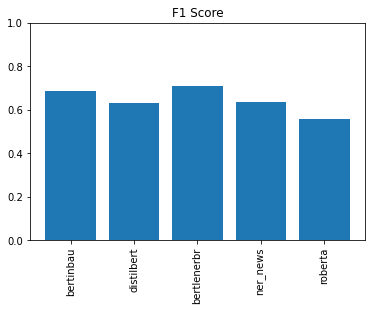

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4]
[0.5743102249014607, 0.5133677298311445, 0.6066590126291618, 0.48663419270523944, 0.47194135490394334]


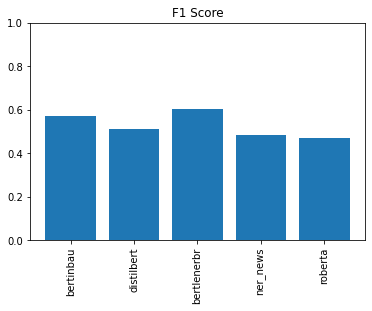

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4]
[0.7904011129144447, 0.7349906191369606, 0.799081515499426, 0.672686230248307, 0.6274014155712841]


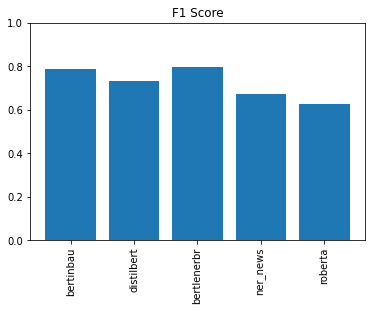

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4]
[0.5766287966612567, 0.5175891181988743, 0.6091848450057407, 0.5400974218842818, 0.47446916076845297]


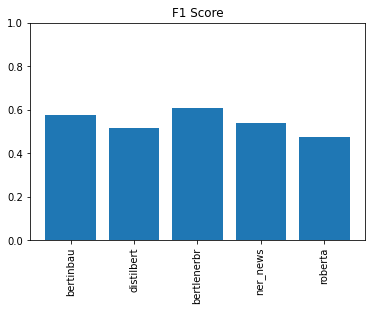

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.5391304347826087, 0.40425531914893614, 0.8438095238095238, 0.868924889543446, 0.9366925064599483, 0.42122448979591837, 0.9546061415220294, 0.8939617083946982, 0.7733089579524681, 0.885952712100139, 0.5501392757660167, 0.4988452655889146, 0.3377643504531722, 0.8446969696969697, 0.8439393939393939, 0.8833551769331585, 0.4233076263924593, 0.7856025039123631, 0.8408736349453979, 0.7689463955637706, 0.8422459893048128, 0.4807436918990704, 0.536144578313253, 0.3921034717494895, 0.8800738007380073, 0.8587896253602306, 0.924433249370277, 0.5017361111111112, 0.9637096774193549, 0.9131693198263386, 0.7815275310834814, 0.8799076212471133, 0.5724533715925394, 0.37564766839378244, 0.40378343118069143, 0.771255060728745, 0.6

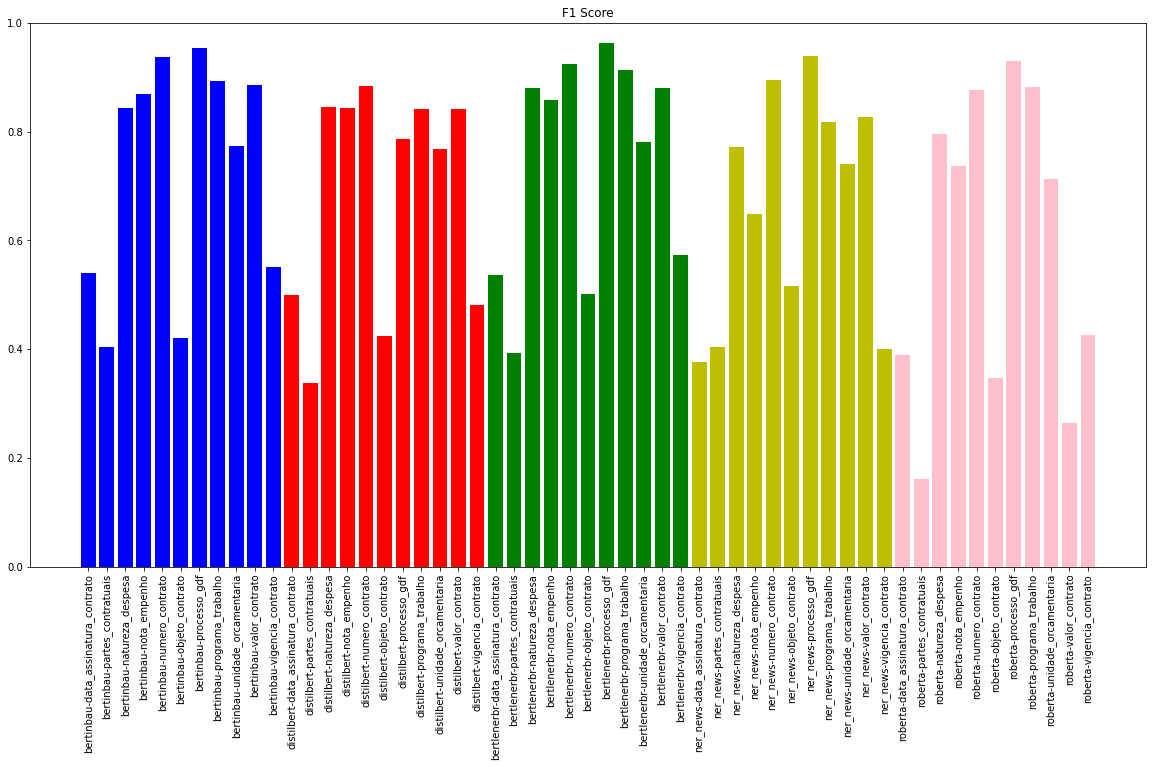

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news', 'roberta']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.5391304347826087, 0.40425531914893614, 0.8438095238095238, 0.868924889543446, 0.9366925064599483, 0.42122448979591837, 0.9546061415220294, 0.8939617083946982, 0.7733089579524681, 0.885952712100139, 0.5501392757660167, 0.4988452655889146, 0.3377643504531722, 0.8446969696969697, 0.8439393939393939, 0.8833551769331585, 0.4233076263924593, 0.7856025039123631, 0.8408736349453979, 0.7689463955637706, 0.8422459893048128, 0.4807436918990704, 0.536144578313253, 0.3921034717494895, 0.8800738007380073, 0.8587896253602306, 0.924433249370277, 0.5017361111111112, 0.9637096774193549, 0.9131693198263386, 0.7815275310834814, 0.8799076212471133, 0.5724533715925394, 0.37564766839378244, 0.40378343118069143, 0.771255060728745, 0.6

Text(0.5, 1.0, 'F1 Score')

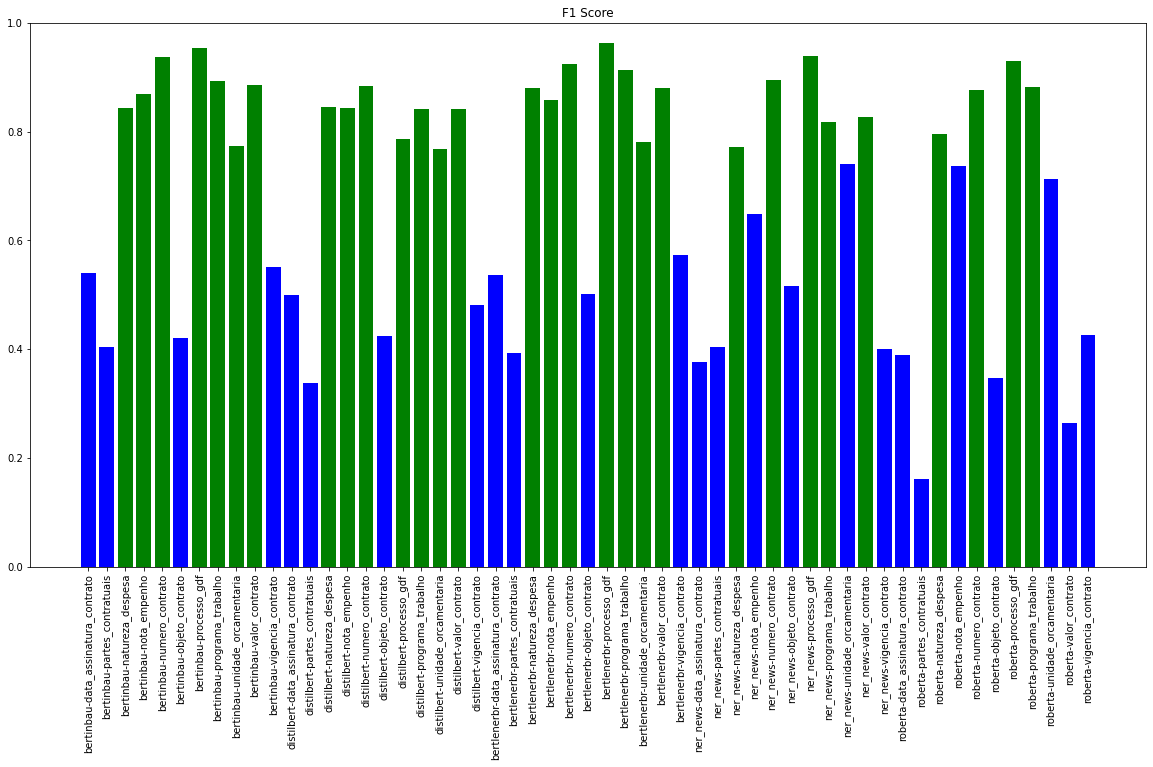

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
